# Réseau de transfert neuronal
Importer et définir des fonctions utiles


In [43]:
# @title Importer et définir des fonctions utiles { display-mode: "form" }
import imageio  # Pour lire et écrire des images
import glob  # Pour manipuler les chemins de fichiers avec des motifs globaux
from tqdm import tqdm  # Barre de progression pour visualiser les boucles longues
import time  # Pour mesurer les performances ou ajouter des délais

# Installation d'un package depuis GitHub pour les tutoriels TensorFlow
!pip install -q git+https://github.com/tensorflow/docs

import os  # Gestion des chemins de fichiers et des variables d'environnement
import tensorflow as tf  # Bibliothèque principale pour l'apprentissage profond

# Configuration pour charger des modèles TensorFlow compressés
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display  # Pour afficher des médias dans un notebook
from PIL import Image  # Pour manipuler des images

import matplotlib.pyplot as plt  # Pour afficher des graphiques et des images
import matplotlib as mpl  # Pour configurer Matplotlib
mpl.rcParams['figure.figsize'] = (12, 12)  # Taille par défaut des figures
mpl.rcParams['axes.grid'] = False  # Désactive les grilles sur les graphiques

import numpy as np  # Pour les opérations sur les tableaux
import PIL.Image  # Alias pour utiliser des fonctionnalités de Pillow
import time  # Répété ici pour les tests de performance
import functools  # Fournit des outils pour des fonctions avancées comme le cache

from matplotlib import gridspec  # Pour personnaliser la disposition des graphiques
import matplotlib.pylab as plt  # Alias supplémentaire pour Matplotlib
import tensorflow_hub as hub  # Bibliothèque pour charger des modèles TensorFlow pré-entraînés

# Fonction pour convertir un tenseur (TensorFlow) en une image PIL
def tensor_to_image(tensor):
    """
    Convertit un tenseur TensorFlow en une image PIL.

    Paramètres :
    - tensor : tenseur contenant des valeurs dans la plage [0, 1].

    Retourne :
    - Une image au format PIL.Image.
    """
    tensor = tensor * 255  # Mise à l'échelle des valeurs pour les convertir en uint8
    tensor = np.array(tensor, dtype=np.uint8)  # Conversion en tableau numpy
    if np.ndim(tensor) > 3:  # Si le tenseur a plus de 3 dimensions
        assert tensor.shape[0] == 1  # Vérifie qu'il contient un seul lot (batch)
        tensor = tensor[0]  # Supprime la dimension batch
    return PIL.Image.fromarray(tensor)  # Convertit le tableau en image PIL

# Fonction pour recadrer une image au centre
def crop_center(image):
    """
    Recadre une image au centre pour en faire un carré.

    Paramètres :
    - image : tableau ou tenseur contenant l'image à recadrer.

    Retourne :
    - Image recadrée sous forme de tenseur.
    """
    shape = image.shape  # Récupère les dimensions de l'image
    new_shape = min(shape[1], shape[2])  # Taille du plus petit côté pour le carré
    offset_y = max(shape[1] - shape[2], 0) // 2  # Décalage en hauteur
    offset_x = max(shape[2] - shape[1], 0) // 2  # Décalage en largeur
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, new_shape, new_shape)  # Recadrage au centre
    return image

# Fonction avec cache pour charger et prétraiter les images
@functools.lru_cache(maxsize=None)
def load_image(image_url, image_name, image_size=(256, 256), preserve_aspect_ratio=True):
    """
    Charge et prétraite une image à partir d'une URL.

    Paramètres :
    - image_url : URL de l'image à charger.
    - image_name : Nom sous lequel l'image sera téléchargée.
    - image_size : Taille cible pour le redimensionnement.
    - preserve_aspect_ratio : Conserve ou non le ratio d'aspect d'origine.

    Retourne :
    - L'image sous forme de tenseur normalisé (valeurs entre 0 et 1).
    """
    # Télécharge l'image localement
    print(os.path.basename(image_url))  # Affiche le nom du fichier téléchargé
    image_path = tf.keras.utils.get_file(os.path.basename(image_url), image_url)

    # Charge l'image et convertit en tableau numpy de type float32
    img = plt.imread(image_path)[:, :, :3].astype(np.float32)[np.newaxis, ...]
    print(img.shape)  # Affiche la forme de l'image

    # Normalisation des valeurs si elles ne sont pas déjà dans [0, 1]
    if img.max() > 1.0:
        img = img / 255.

    # Si l'image est monochrome, elle est convertie en 3 canaux
    if len(img.shape) == 3:
        img = tf.stack([img, img, img], axis=-1)

    # Recadrage au centre et redimensionnement
    img = crop_center(img)
    img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
    return img

# Fonction pour afficher plusieurs images côte à côte
def show_n(images, titles=('',)):
    """
    Affiche une série d'images côte à côte avec des titres optionnels.

    Paramètres :
    - images : Liste de tenseurs ou tableaux numpy représentant les images.
    - titles : Liste des titres à afficher sous chaque image.
    """
    n = len(images)  # Nombre d'images à afficher
    image_sizes = [image.shape[1] for image in images]  # Tailles des images
    w = (image_sizes[0] * 6) // 320  # Calcul de la largeur relative des figures
    plt.figure(figsize=(w * n, w))  # Crée une figure avec une taille appropriée

    # Utilisation de GridSpec pour une disposition flexible
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
        plt.subplot(gs[i])  # Ajoute un sous-graphe
        plt.imshow(images[i][0], aspect='equal')  # Affiche l'image
        plt.axis('off')  # Supprime les axes
        plt.title(titles[i] if len(titles) > i else '')  # Ajoute le titre

    # Sauvegarde de la figure générée
    fig = plt.gcf()  # Récupère la figure courante
    fig.savefig('all_images_generated_fast.png')  # Sauvegarde la figure en tant que fichier

    # Affiche la figure dans le notebook
    plt.show()

    # Téléchargement automatique si sur Google Colab
    try:
        from google.colab import files
    except ImportError:
        pass
    else:
        files.download('all_images_generated_fast.png')



  Preparing metadata (setup.py) ... done


# Chargement des exemples d'images                       

In [ ]:
# @title Charger des exemples d'images  { display-mode: "form" ,  run: "auto" }

github_raw_url = 'Choisir celui de votre choix :)'  # @param {type:"string"}

# Exemple d'URLs d'images
content_image_name = " Choix de votre image "  # @param ["image 1","image 2", etc.]
style_image_name = " Choix de votre image"  # @param ["image 1","image 2", etc.]

# Taille des images
output_image_size = 256  # @param {type:"integer"}
content_img_size = (output_image_size, output_image_size)
style_img_size = (output_image_size, output_image_size)

# Charger les images
def validate_url(url):
    """Vérifie si l'URL est accessible."""
    import requests
    try:
        response = requests.head(url)
        return response.status_code == 200
    except Exception as e:
        print(f"Erreur lors de la validation de l'URL {url}: {e}")
        return False

if validate_url(content_image_name) and validate_url(style_image_name):
    content_image = load_image(content_image_name, content_img_size)
    style_image = load_image(style_image_name, style_img_size)
    show_n([content_image, style_image], ['Content Image', 'Style Image'])
else:
    print("L'une des URLs est invalide.")


tf.keras.utils.plot_model(
    tf.keras.applications.VGG19(include_top=True, weights='imagenet'))

tf.keras.utils.plot_model(
    tf.keras.applications.VGG19(include_top=False, weights='imagenet'))

for layer in tf.keras.applications.VGG19(include_top=False, weights='imagenet').layers:
    print(layer.name)


def combine_styles(style_images, extractor, weights):
    style_targets = [extractor(style)['style'] for style in style_images]
    combined_style = {}
    for name in style_targets[0]:
        combined_style[name] = tf.add_n([style_targets[i][name] * weights[i]
                                         for i in range(len(style_images))])
    return combined_style


def preserve_colors(content_image, stylized_image):
    content_lab = tf.image.rgb_to_yuv(content_image)
    stylized_lab = tf.image.rgb_to_yuv(stylized_image)
    stylized_lab = tf.concat([stylized_lab[..., 0:1], content_lab[..., 1:]], axis=-1)
    return tf.image.yuv_to_rgb(stylized_lab)


# Définir un modèle

In [36]:
import tensorflow as tf

# Définition des couches
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layers = ['block5_conv2']

style_layer_weights = {
    'block1_conv1': 1.0,
    'block2_conv1': 0.8,
    'block3_conv1': 0.6,
    'block4_conv1': 0.4,
    'block5_conv1': 0.2
}

content_layer_weights = {
    'block5_conv2': 1.0
}

# Fonction pour calculer la matrice de Gram
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

# Fonction pour récupérer les couches VGG19
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    return tf.keras.Model([vgg.input], outputs)

# Modèle pour extraire le style et le contenu
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name: value for content_name, value in
                        zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in
                      zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}

# Initialisation des modèles et images d'entrée
extractor = StyleContentModel(style_layers, content_layers)

# Exemple d'image combinée
combined_image = tf.random.uniform((1, 256, 256, 3))  # Image aléatoire pour exemple
style_image = tf.random.uniform((1, 256, 256, 3))     # Image de style pour exemple

# Extraction des cibles de style
style_targets = extractor(style_image)['style']
combined_style_targets = style_targets

# Calcul des sorties de style
outputs = extractor(combined_image)
style_outputs = outputs['style']

# Calcul de la perte de style
style_loss = tf.add_n([tf.reduce_mean(tf.square(style_outputs[name] - combined_style_targets[name]))
                       for name in style_outputs.keys()])

print(f"Style Loss: {style_loss}")



Style Loss: 1595191040.0


# Entraînement et génération

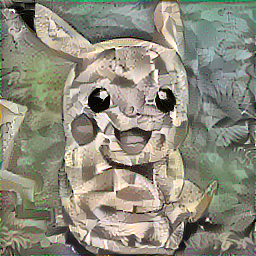

Train step: 1000


In [31]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']


!rm stylized-image-*.png

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

style_weight=1e-2
content_weight=1e3

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean(tf.square((style_outputs[name]-style_targets[name])))
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean(tf.square((content_outputs[name]-content_targets[name])))
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

total_variation_weight=50
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

image = tf.Variable(content_image)
#image = tf.Variable(np.random.rand(1,256,256,3))

epochs = 10
steps_per_epoch = 100
max_step = epochs * steps_per_epoch
step_to_save = max_step*0.1

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
    if step%step_to_save ==0:
        print(f'STEP: {step} SAVING..')
        file_name = f'stylized-image-{step}.png'
        tensor_to_image(image).save(file_name)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))


# Sauvegarde et téléchargement de l'image générée

In [42]:
# @title Sauvegarde et téléchargement de l'image générée...  { display-mode: "form" }

import numpy as np
from PIL import Image

def preserve_colors(content_image, stylized_image):
    # Implémentez ici la logique de préservation des couleurs (exemple temporaire)
    return stylized_image  # Retour temporaire pour débogage

# Conversion et sauvegarde
print('SAVING AND DOWNLOADING GENERATED IMAGE...')
file_name = f'stylized-image-{step}.png'
tensor_to_image(image).save(file_name)

try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(file_name)

print('SAVING AND DOWNLOADING GENERATED IMAGE DONE')

stylized_image = tensor_to_image(image)

# Assurez-vous que preserve_colors renvoie une image compatible
color_preserved_image = preserve_colors(content_image, stylized_image)

# Si l'image est un objet PIL.Image, convertissez-la en tableau numpy
if isinstance(color_preserved_image, Image.Image):
    color_preserved_image = np.array(color_preserved_image)

# Conversion au type uint8
if color_preserved_image.dtype != np.uint8:
    color_preserved_image = np.clip(color_preserved_image, 0, 255).astype(np.uint8)

# Sauvegarde de l'image finale
Image.fromarray(color_preserved_image).save('color_preserved_stylized_image.png')



SAVING AND DOWNLOADING GENERATED IMAGE...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SAVING AND DOWNLOADING GENERATED IMAGE DONE


# Style rapide

In [ ]:
#https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
generated_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
#tensor_to_image(stylized_image)
tensor_to_image(content_image).save('content_image.jpg')
tensor_to_image(style_image).save('style_image.jpg')
tensor_to_image(generated_image).save('generated_image.jpg')

try:
  from google.colab import files
except ImportError:
   pass
else:
  for file_ in ['content_image.jpg', 'style_image.jpg', 'generated_image.jpg']:
    files.download(file_)

show_n([content_image, style_image, generated_image], titles=['Content Image', 'Style Image', 'Generated Image'])

